In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((11-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
# del cm_target[1,2,7,10,13]
cm_target = cm_target[7:10]

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<11))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<11))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = np.concatenate((h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - heights of Gurney flaps:  (3000, 1)
Dimension - inclination(beta):  (3000, 1)
Dimension - x:  (3000, 3)
Dimension - y:  (3000, 1)


In [21]:
x[:,0] -= 10
x[:,0] /= 5

In [22]:
x[:,0]

array([0.    , 0.0002, 0.0004, ..., 0.1994, 0.1996, 0.1998])

In [23]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [24]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [25]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [26]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [28]:
model_directory = "D:\\TrainedModels\\20221230\\3beta"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [29]:
#ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_10h_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

#ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.1,
                                          min_delta = 1e-5, min_lr=1e-05, verbose=1)

In [30]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [31]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
10/10 [==============================] - 1s 25ms/step - loss: 0.1514 - rmse: 0.3890 - val_loss: 0.1187 - val_rmse: 0.3444 - lr: 1.0000e-04
Epoch 2/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0857 - rmse: 0.2926 - val_loss: 0.0698 - val_rmse: 0.2639 - lr: 1.0000e-04
Epoch 3/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0626 - rmse: 0.2500 - val_loss: 0.0657 - val_rmse: 0.2561 - lr: 1.0000e-04
Epoch 4/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0616 - rmse: 0.2480 - val_loss: 0.0632 - val_rmse: 0.2512 - lr: 1.0000e-04
Epoch 5/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0586 - rmse: 0.2418 - val_loss: 0.0638 - val_rmse: 0.2524 - lr: 1.0000e-04
Epoch 6/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0610 - rmse: 0.2468 - val_loss: 0.0627 - val_rmse: 0.2502 - lr: 1.0000e-04
Epoch 7/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.0597 - rms

10/10 [==============================] - 0s 8ms/step - loss: 0.0545 - rmse: 0.2333 - val_loss: 0.0563 - val_rmse: 0.2370 - lr: 1.0000e-04
Epoch 55/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0528 - rmse: 0.2296 - val_loss: 0.0556 - val_rmse: 0.2356 - lr: 1.0000e-04
Epoch 56/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0527 - rmse: 0.2293 - val_loss: 0.0558 - val_rmse: 0.2361 - lr: 1.0000e-04
Epoch 57/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0521 - rmse: 0.2281 - val_loss: 0.0555 - val_rmse: 0.2355 - lr: 1.0000e-04
Epoch 58/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0508 - rmse: 0.2252 - val_loss: 0.0555 - val_rmse: 0.2354 - lr: 1.0000e-04
Epoch 59/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0553 - val_rmse: 0.2349 - lr: 1.0000e-04
Epoch 60/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.0527 - rmse: 0.2294

10/10 [==============================] - 0s 10ms/step - loss: 0.0055 - rmse: 0.0734 - val_loss: 0.0054 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 108/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0052 - rmse: 0.0712 - val_loss: 0.0054 - val_rmse: 0.0731 - lr: 1.0000e-04
Epoch 109/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0045 - rmse: 0.0664 - val_loss: 0.0046 - val_rmse: 0.0674 - lr: 1.0000e-04
Epoch 110/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0044 - val_rmse: 0.0660 - lr: 1.0000e-04
Epoch 111/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0039 - rmse: 0.0615 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 112/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 113/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0034 -

Epoch 159/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.6195e-04 - rmse: 0.0193 - val_loss: 6.0892e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 160/10000
10/10 [==============================] - 0s 10ms/step - loss: 5.1723e-04 - rmse: 0.0207 - val_loss: 6.0830e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 161/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.3649e-04 - rmse: 0.0186 - val_loss: 5.4880e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 162/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.5172e-04 - rmse: 0.0190 - val_loss: 5.4025e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 163/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.7330e-04 - rmse: 0.0196 - val_loss: 5.6080e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 164/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.5380e-04 - rmse: 0.0191 - val_loss: 4.9566e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 165/10000
10/10 

10/10 [==============================] - 0s 10ms/step - loss: 2.2038e-04 - rmse: 0.0117 - val_loss: 2.9351e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 210/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.3594e-04 - rmse: 0.0123 - val_loss: 2.5312e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 211/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.0426e-04 - rmse: 0.0110 - val_loss: 2.4530e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 212/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.8912e-04 - rmse: 0.0103 - val_loss: 2.4032e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 213/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.9555e-04 - rmse: 0.0106 - val_loss: 2.6256e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 214/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.8401e-04 - rmse: 0.0100 - val_loss: 2.3202e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 215/10000
10/10 [===============

10/10 [==============================] - 0s 11ms/step - loss: 1.5076e-04 - rmse: 0.0085 - val_loss: 1.8714e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 260/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4729e-04 - rmse: 0.0083 - val_loss: 1.8857e-04 - val_rmse: 0.0105 - lr: 1.0000e-04
Epoch 261/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4720e-04 - rmse: 0.0083 - val_loss: 1.6818e-04 - val_rmse: 0.0095 - lr: 1.0000e-04
Epoch 262/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4001e-04 - rmse: 0.0078 - val_loss: 1.9034e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 263/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.4723e-04 - rmse: 0.0083 - val_loss: 1.7930e-04 - val_rmse: 0.0101 - lr: 1.0000e-04
Epoch 264/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.4821e-04 - rmse: 0.0084 - val_loss: 1.6951e-04 - val_rmse: 0.0096 - lr: 1.0000e-04
Epoch 265/10000
10/10 [===============

10/10 [==============================] - 0s 11ms/step - loss: 1.2930e-04 - rmse: 0.0074 - val_loss: 1.5773e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 310/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4407e-04 - rmse: 0.0084 - val_loss: 1.6357e-04 - val_rmse: 0.0095 - lr: 1.0000e-04
Epoch 311/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.5169e-04 - rmse: 0.0088 - val_loss: 1.8196e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 312/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.7401e-04 - rmse: 0.0100 - val_loss: 1.7908e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 313/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.4254e-04 - rmse: 0.0083 - val_loss: 1.6015e-04 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 314/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.2667e-04 - rmse: 0.0073 - val_loss: 1.4517e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 315/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 1.1431e-04 - rmse: 0.0066 - val_loss: 1.2429e-04 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 360/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1173e-04 - rmse: 0.0065 - val_loss: 1.5187e-04 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 361/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.2962e-04 - rmse: 0.0077 - val_loss: 1.4736e-04 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 362/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4232e-04 - rmse: 0.0085 - val_loss: 1.5389e-04 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 363/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4517e-04 - rmse: 0.0087 - val_loss: 1.8302e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 364/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.4046e-04 - rmse: 0.0084 - val_loss: 1.5278e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 365/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 1.1217e-04 - rmse: 0.0068 - val_loss: 1.4658e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 410/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1702e-04 - rmse: 0.0071 - val_loss: 1.1201e-04 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 411/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1557e-04 - rmse: 0.0070 - val_loss: 1.3006e-04 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 412/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1385e-04 - rmse: 0.0069 - val_loss: 1.1766e-04 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 413/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.2640e-04 - rmse: 0.0078 - val_loss: 1.4811e-04 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 414/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.0781e-04 - rmse: 0.0064 - val_loss: 1.4936e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 415/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 1.6631e-04 - rmse: 0.0101 - val_loss: 1.1382e-04 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 460/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.4642e-04 - rmse: 0.0091 - val_loss: 1.3020e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 461/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.3591e-04 - rmse: 0.0085 - val_loss: 1.1188e-04 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 462/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1968e-04 - rmse: 0.0075 - val_loss: 1.2980e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 463/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.6989e-04 - rmse: 0.0103 - val_loss: 1.6183e-04 - val_rmse: 0.0099 - lr: 1.0000e-04
Epoch 464/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.5762e-04 - rmse: 0.0097 - val_loss: 1.4154e-04 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 465/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 9.5936e-05 - rmse: 0.0059 - val_loss: 1.1343e-04 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 510/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.8825e-05 - rmse: 0.0062 - val_loss: 1.0483e-04 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 511/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1410e-04 - rmse: 0.0073 - val_loss: 1.1257e-04 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 512/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.9403e-05 - rmse: 0.0062 - val_loss: 1.1183e-04 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 513/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1488e-04 - rmse: 0.0074 - val_loss: 9.5838e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 514/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.0521e-04 - rmse: 0.0067 - val_loss: 1.1064e-04 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 515/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 1.0298e-04 - rmse: 0.0067 - val_loss: 9.6299e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 560/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.5925e-05 - rmse: 0.0061 - val_loss: 1.0588e-04 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 561/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.6045e-05 - rmse: 0.0061 - val_loss: 1.0982e-04 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 562/10000
10/10 [==============================] - 0s 11ms/step - loss: 1.0116e-04 - rmse: 0.0065 - val_loss: 1.0534e-04 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 563/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.0386e-04 - rmse: 0.0067 - val_loss: 1.1265e-04 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 564/10000
10/10 [==============================] - 0s 10ms/step - loss: 9.3934e-05 - rmse: 0.0060 - val_loss: 8.9627e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 565/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 7.9064e-05 - rmse: 0.0046 - val_loss: 8.4935e-05 - val_rmse: 0.0052 - lr: 1.0000e-05
Epoch 609/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6181e-05 - rmse: 0.0043 - val_loss: 8.5642e-05 - val_rmse: 0.0053 - lr: 1.0000e-05
Epoch 610/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.0961e-05 - rmse: 0.0048 - val_loss: 8.2339e-05 - val_rmse: 0.0050 - lr: 1.0000e-05
Epoch 611/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6090e-05 - rmse: 0.0043 - val_loss: 8.4481e-05 - val_rmse: 0.0052 - lr: 1.0000e-05
Epoch 612/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.0367e-05 - rmse: 0.0048 - val_loss: 8.2650e-05 - val_rmse: 0.0050 - lr: 1.0000e-05
Epoch 613/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.7610e-05 - rmse: 0.0045 - val_loss: 8.3328e-05 - val_rmse: 0.0051 - lr: 1.0000e-05
Epoch 614/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 7.8167e-05 - rmse: 0.0046 - val_loss: 8.4463e-05 - val_rmse: 0.0052 - lr: 1.0000e-05
Epoch 659/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.6310e-05 - rmse: 0.0044 - val_loss: 8.2444e-05 - val_rmse: 0.0050 - lr: 1.0000e-05
Epoch 660/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.7963e-05 - rmse: 0.0045 - val_loss: 8.3900e-05 - val_rmse: 0.0052 - lr: 1.0000e-05
Epoch 661/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.7098e-05 - rmse: 0.0044 - val_loss: 8.3881e-05 - val_rmse: 0.0051 - lr: 1.0000e-05
Epoch 662/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.3736e-05 - rmse: 0.0040 - val_loss: 8.3848e-05 - val_rmse: 0.0051 - lr: 1.0000e-05
Epoch 663/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.0815e-05 - rmse: 0.0048 - val_loss: 7.9739e-05 - val_rmse: 0.0047 - lr: 1.0000e-05
Epoch 664/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 7.9292e-05 - rmse: 0.0047 - val_loss: 8.1109e-05 - val_rmse: 0.0049 - lr: 1.0000e-05
Epoch 709/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.9239e-05 - rmse: 0.0047 - val_loss: 8.4057e-05 - val_rmse: 0.0052 - lr: 1.0000e-05
Epoch 710/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4883e-05 - rmse: 0.0042 - val_loss: 8.2889e-05 - val_rmse: 0.0051 - lr: 1.0000e-05
Epoch 711/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.8701e-05 - rmse: 0.0046 - val_loss: 8.3000e-05 - val_rmse: 0.0051 - lr: 1.0000e-05
Epoch 712/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4813e-05 - rmse: 0.0042 - val_loss: 8.2005e-05 - val_rmse: 0.0050 - lr: 1.0000e-05
Epoch 713/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.4346e-05 - rmse: 0.0041 - val_loss: 8.4794e-05 - val_rmse: 0.0053 - lr: 1.0000e-05
Epoch 714/10000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 7.4479e-05 - rmse: 0.0042 - val_loss: 8.1121e-05 - val_rmse: 0.0049 - lr: 1.0000e-05
Epoch 759/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6939e-05 - rmse: 0.0045 - val_loss: 8.0810e-05 - val_rmse: 0.0049 - lr: 1.0000e-05
Epoch 760/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6526e-05 - rmse: 0.0044 - val_loss: 8.1703e-05 - val_rmse: 0.0050 - lr: 1.0000e-05
Epoch 761/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6618e-05 - rmse: 0.0044 - val_loss: 8.1729e-05 - val_rmse: 0.0050 - lr: 1.0000e-05
Epoch 762/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6655e-05 - rmse: 0.0044 - val_loss: 8.2134e-05 - val_rmse: 0.0050 - lr: 1.0000e-05
Epoch 763/10000
10/10 [==============================] - 0s 10ms/step - loss: 7.6915e-05 - rmse: 0.0045 - val_loss: 8.1627e-05 - val_rmse: 0.0050 - lr: 1.0000e-05
Epoch 764/10000
10/10 [===============

In [32]:
time = end - start
print("Training time:", time)

Training time: 0:01:20.646654


In [33]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221230_MLP_3beta\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

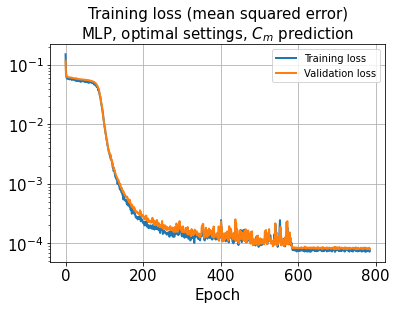

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

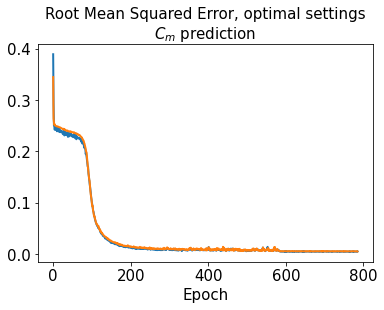

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

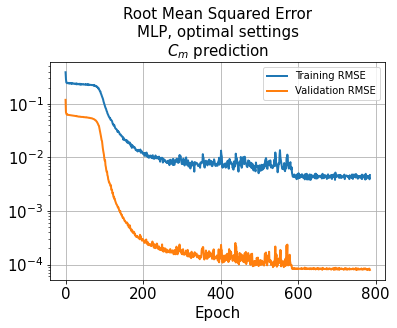

In [36]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [37]:
train_results = model.evaluate(x_train, y_train)

66/66 [==============================] - 0s 4ms/step - loss: 7.7638e-05 - rmse: 0.0045


In [38]:
val_results = model.evaluate(x_val, y_val)

19/19 [==============================] - 0s 4ms/step - loss: 8.3017e-05 - rmse: 0.0050


In [39]:
test_results = model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 7.4981e-05 - rmse: 0.0042


In [40]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

10/10 [==============================] - 0s 2ms/step


In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [45]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.010238493231951548
0.3279456284397622


In [47]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.011303718165689132
0.3576642144314155


In [48]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.010163739943415327
0.3642668368487374


In [49]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [50]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [51]:
model_directory = "D:\\TrainedModels\\20221230"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230unsteadyValidation_MLP_3beta_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [52]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [53]:
os.chdir(storage_dir)

In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

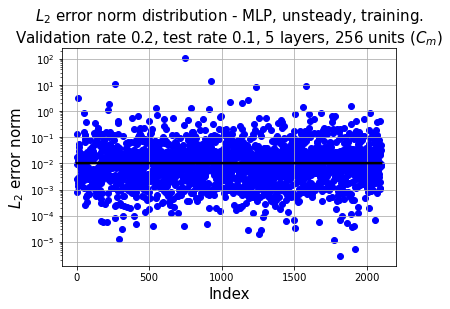

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

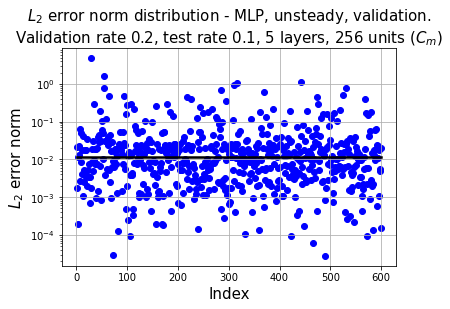

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

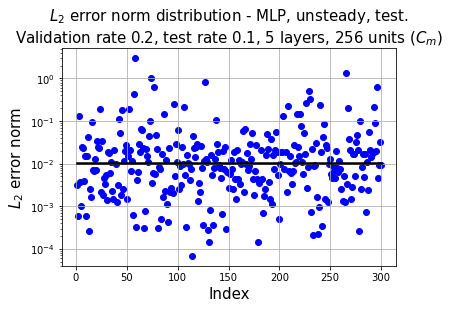

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

94/94 [==============================] - 0s 2ms/step


In [65]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [66]:
index_train.shape

(2100,)

In [67]:
max(predicted)

array([1.0040348], dtype=float32)

In [69]:
l2_error(predicted, y)

0.010463685493767184

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
x[:,0] *= 5
x[:,0] += 10

In [77]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0152


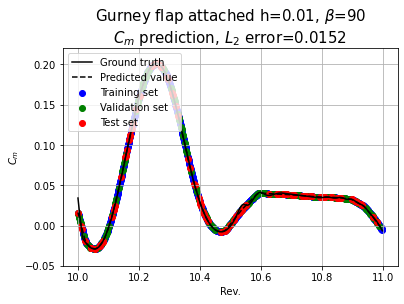

L2 error of Cm: 0.0068


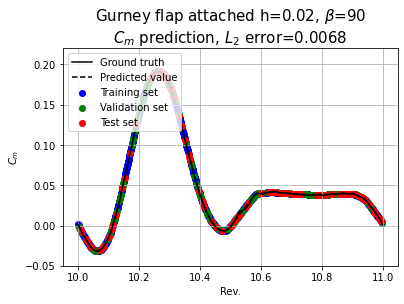

L2 error of Cm: 0.0065


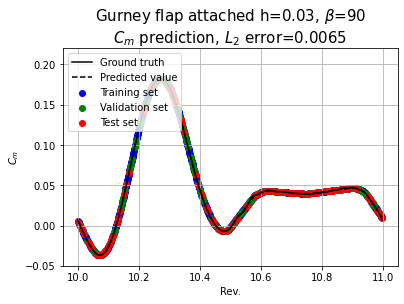

In [78]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [79]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
#     title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0152


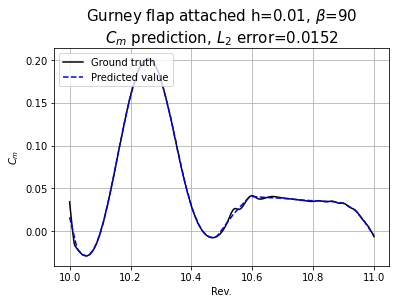

L2 error of Cm: 0.0068


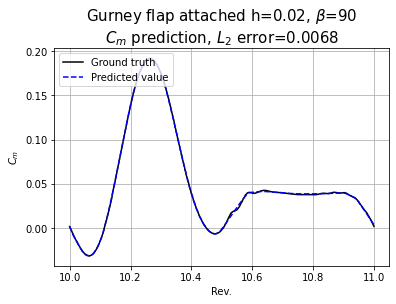

L2 error of Cm: 0.0065


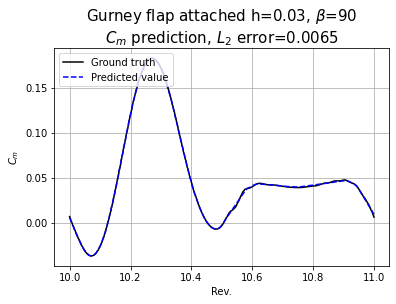

In [80]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0152


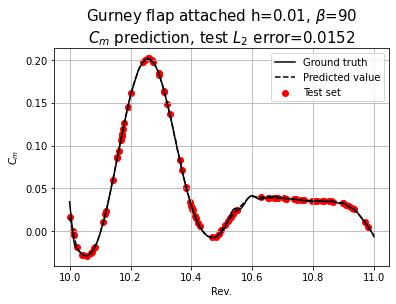

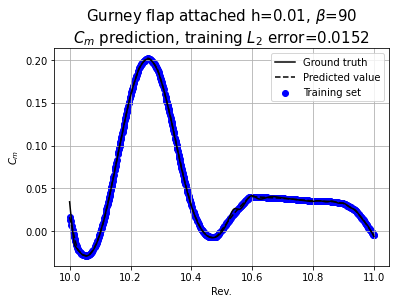

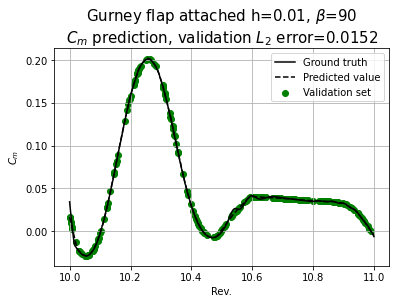

L2 error of Cm: 0.0068


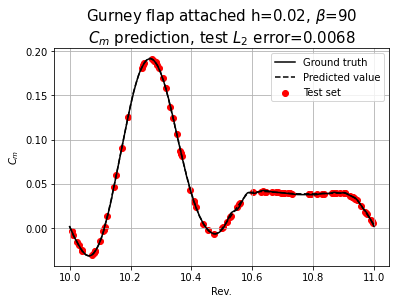

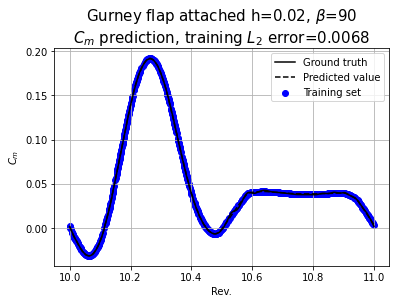

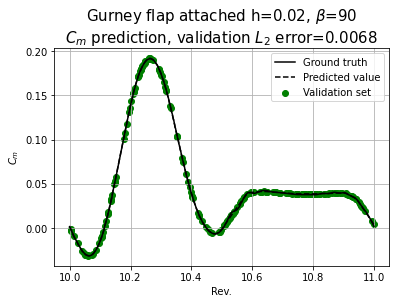

L2 error of Cm: 0.0065


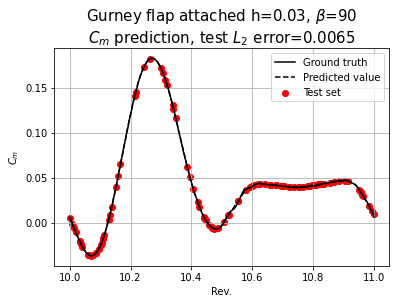

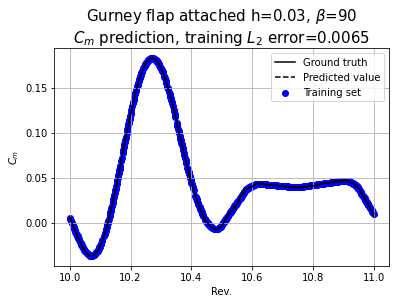

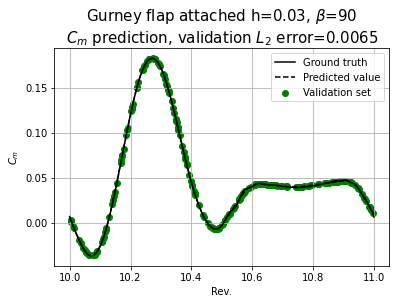

In [82]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    title_train = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_Cm)
    title_val = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_Cm)
    title_test = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_Cm)
    title_Cm = title_n_Cm
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"training.jpg"
    savename2 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"validation.jpg"
    savename3 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"test.jpg"
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_test, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename3, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_train, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_val, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()